<a href="https://colab.research.google.com/github/jedhouas/Advanced-Deep-Learning/blob/master/TP1_Ex2_Multiclass_Working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-classification problem

__Note:__ you might need to do
`conda install torchvision "pillow<7"`
if torchvision is not already installed on your computer, and/or for compatibility issues (the version of torchvision version supporting the last version of Pillow is not released yet).

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np 
import matplotlib.pyplot as plt
import imgaug as ia
import PIL
import copy
%matplotlib inline

### [MNIST Dataset](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist)
* Handwritten digits with 10 classes
* the size of each image is 28x28 pixels 
* 50 000 data examples in training set, 10 000 examples in validation set, 10 000 in test set

In [0]:
# Loading MNIST dataset from torchvision.dataset
dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)
mean=dataset.data.float().mean()/255
std=dataset.data.float().std()/255


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [0]:
print("The shape of the dataset is :", dataset.data.size())

The shape of the dataset is : torch.Size([60000, 28, 28])


# Data Augmentation : 
I'll be using a data augmentation pipeline  using Torchvision 

In [0]:
# Applying image Augmentation techniques 
data_transforms = {
    'train': torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=(-10,10),expand=True),
    torchvision.transforms.Resize((28, 28)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[mean],std=[std])
]),
    'val': torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[mean],std=[std])
                                 
])
}

In [0]:
# Loading MNIST dataset from torchvision.dataset
dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True, 
                                           transform=data_transforms['val'],
                                           download=True)

In [0]:
print("The shape of the dataset is :", dataset.data.size())

The shape of the dataset is : torch.Size([60000, 28, 28])


In [0]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [50000, 10000])

Text(0.5, 1.0, 'image label: 6')

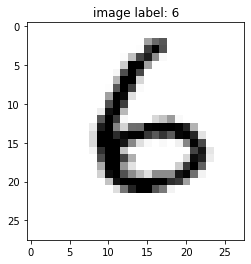

In [0]:
sample_index = np.random.randint(5000)
plt.imshow(dataset.__getitem__(sample_index)[0][0], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])

### Training the neural network
The Model is Highly inspired from VGGNet, several 3 groups of CNNs (Groups of 3 in general + Maxpooling and Dropout ) 

In [0]:
class Model(nn.Module):
    def __init__(self,drop):
        super(Model, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),nn.ReLU(),nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),nn.ReLU(),nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),nn.ReLU(),nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),nn.Dropout(drop)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),nn.ReLU(),nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),nn.ReLU(),nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),nn.ReLU(),nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),nn.Dropout(drop)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),nn.ReLU(),nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),nn.Dropout(drop)
        )
        
        self.lin = nn.Sequential(
            nn.Linear(128, 10)
        )
                
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        return self.lin(x)

In [0]:
if torch.cuda.is_available :
  device=torch.device('cuda')
else:
  device=torch.device('cpu')

In [0]:

# Create the model: 
model = Model(drop=0.3)
model.to(device)
# Choose the hyperparameters for training: 
num_epochs = 100
batch_size = 64

# Use mean squared loss function 
criterion = nn.CrossEntropyLoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [0]:
loader

NameError: ignored

In [0]:
# define a function for training
def Train_model(model,criterion,optimizer,loader,device,scheduler=None,mode='train'):
  """Model Training/Validation
  ------------------------------
  Output:
  -----------
  mean_loss: Mean loss over Epoch"""


  if mode=='train':
    model.train()
  elif mode=='val':
    model.eval()
  else:
    print('mode should be Train or Val')
    return
  losses=[]
  Preds=[]
  Actual=[]
  correct = 0
  total = 0
  for inputs, labels in loader:
    inputs, labels = inputs.to(device), labels.long().to(device)
    batch_size=inputs.size(0)
    #inputs=inputs.reshape(batch_size,-1)
    optimizer.zero_grad()
    with torch.set_grad_enabled(mode=='train'):
      output = model(inputs)
      loss = criterion(output, labels)
      _,pred=torch.max(output, 1)
      if mode=='train':
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    #Preds=np.append(Preds,pred.cpu().long().numpy())
    #Actual=np.append(Actual,labels.cpu().long().numpy())
    correct+=float(torch.sum(pred==labels.data))
    total+=float(inputs.shape[0])

  if mode =='train' and scheduler!=None:
    scheduler.step()
  mean_loss=np.mean(losses)
  print('{} Loss {:.4f}  Acc : {:.2%}  '.format(mode,mean_loss,correct/total))
  return mean_loss

In [0]:
train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size, shuffle=True)

In [0]:
train_set.data.size()

AttributeError: ignored

In [0]:
train_error=[]
val_error=[] 
best_loss=10 #just some error value here 
for epoch in range(num_epochs):
  print('epoch: ',epoch)
  train_error+=[Train_model(model,criterion,optimizer,train_loader,device,mode='train')]
  val_error+=[Train_model(model,criterion,optimizer,val_loader,device,mode='val')]
  if val_error[-1] < best_loss:
    #Saving best State
    best_loss=val_error[-1]
    best_w = copy.deepcopy(model.state_dict())
    best_epoch=epoch  
model.load_state_dict(best_w)

In [0]:
torch.save(best_w,'best_w.pth')

Text(0.5, 1.0, 'Visualization of convergence')

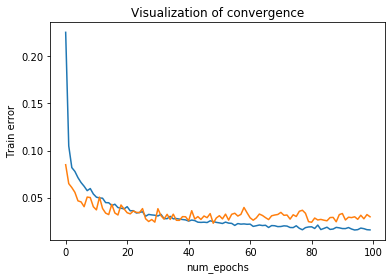

In [0]:
# plot the training error wrt. the number of epochs: 
plt.plot(train_error,label='Train error')
plt.plot(val_error,label='Val error')
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the Model on validation set

Text(0.5, 1.0, 'Prediction label: 7')

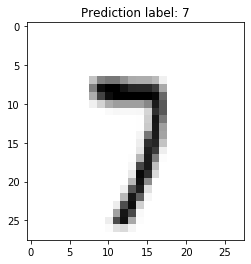

In [0]:
val_index = 66
(image, label) = val_set[val_index]
output = model(image.unsqueeze(0).to(device))
_, prediction = torch.max(output.data, 1)
plt.imshow(image.view(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

In [0]:
class Model(nn.Module):
    def __init__(self,drop):
        super(Model, self).__init__()
        """Architecture Inspired from VGGNet"""

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 128, 5, padding=1,stride=2),nn.ReLU(),nn.BatchNorm2d(128),
            nn.Conv2d(128, 64, 3, padding=1),nn.ReLU(),nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),nn.Dropout(drop),
            nn.Conv2d(64, 64, 3, padding=1),nn.ReLU(),nn.BatchNorm2d(64),
            nn.Conv2d(64, 32, 3, padding=1),nn.ReLU(),nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),nn.Dropout(drop)
        )
        
        self.lin = nn.Sequential(
            nn.Linear(288, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        return self.lin(x)

In [0]:
# Create the model: 
model = Model(drop=0.3)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_error=[]
val_error=[]
best_loss=10 #just some error value here
for epoch in range(25):
  print('epoch: ',epoch)
  train_error+=[Train_model(model,criterion,optimizer,train_loader,device,mode='train')]
  val_error+=[Train_model(model,criterion,optimizer,val_loader,device,mode='val')]
  if val_error[-1] < best_loss:
    #Saving best State
    best_loss=val_error[-1]
    best_w = copy.deepcopy(model.state_dict())
    best_epoch=epoch  
model.load_state_dict(best_w)

epoch:  0
train Loss 0.1506  Acc : 95.32%  
val Loss 0.0497  Acc : 98.24%  
epoch:  1
train Loss 0.0621  Acc : 98.01%  
val Loss 0.0405  Acc : 98.67%  
epoch:  2
train Loss 0.0477  Acc : 98.53%  
val Loss 0.0353  Acc : 98.80%  
epoch:  3
train Loss 0.0468  Acc : 98.55%  
val Loss 0.0305  Acc : 98.97%  
epoch:  4
train Loss 0.0407  Acc : 98.76%  
val Loss 0.0322  Acc : 98.93%  
epoch:  5
train Loss 0.0394  Acc : 98.79%  
val Loss 0.0301  Acc : 98.98%  
epoch:  6
train Loss 0.0353  Acc : 98.86%  
val Loss 0.0280  Acc : 99.07%  
epoch:  7
train Loss 0.0341  Acc : 98.91%  
val Loss 0.0353  Acc : 99.02%  
epoch:  8
train Loss 0.0313  Acc : 99.02%  
val Loss 0.0352  Acc : 99.15%  
epoch:  9
train Loss 0.0308  Acc : 99.00%  
val Loss 0.0327  Acc : 99.09%  
epoch:  10
train Loss 0.0279  Acc : 99.12%  
val Loss 0.0358  Acc : 99.11%  
epoch:  11
train Loss 0.0266  Acc : 99.15%  
val Loss 0.0287  Acc : 99.15%  
epoch:  12
train Loss 0.0267  Acc : 99.13%  
val Loss 0.0252  Acc : 99.25%  
epoch:  1

<All keys matched successfully>

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

In [0]:
# Create the model: 
model = Model(drop=0.3)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

batch_size = 64
train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size, shuffle=True)

train_error=[]
val_error=[]
best_loss=10 #just some error value here
for epoch in range(30):
  print('epoch: ',epoch)
  train_error+=[Train_model(model,criterion,optimizer,train_loader,device,mode='train')]
  val_error+=[Train_model(model,criterion,optimizer,val_loader,device,mode='val')]
  if val_error[-1] < best_loss:
    #Saving best State
    best_loss=val_error[-1]
    best_w = copy.deepcopy(model.state_dict())
    best_epoch=epoch  
model.load_state_dict(best_w)

epoch:  0
train Loss 0.1495  Acc : 95.66%  
val Loss 0.0635  Acc : 97.84%  
epoch:  1
train Loss 0.0542  Acc : 98.27%  
val Loss 0.0348  Acc : 98.87%  
epoch:  2
train Loss 0.0395  Acc : 98.73%  
val Loss 0.0301  Acc : 99.14%  
epoch:  3
train Loss 0.0324  Acc : 98.98%  
val Loss 0.0262  Acc : 99.21%  
epoch:  4
train Loss 0.0254  Acc : 99.13%  
val Loss 0.0263  Acc : 99.26%  
epoch:  5
train Loss 0.0218  Acc : 99.31%  
val Loss 0.0280  Acc : 99.16%  
epoch:  6
train Loss 0.0190  Acc : 99.37%  
val Loss 0.0269  Acc : 99.18%  
epoch:  7
train Loss 0.0173  Acc : 99.43%  
val Loss 0.0273  Acc : 99.21%  
epoch:  8
train Loss 0.0177  Acc : 99.43%  
val Loss 0.0244  Acc : 99.29%  
epoch:  9
train Loss 0.0142  Acc : 99.49%  
val Loss 0.0285  Acc : 99.16%  
epoch:  10
train Loss 0.0125  Acc : 99.60%  
val Loss 0.0284  Acc : 99.23%  
epoch:  11
train Loss 0.0111  Acc : 99.64%  
val Loss 0.0282  Acc : 99.20%  
epoch:  12
train Loss 0.0104  Acc : 99.67%  
val Loss 0.0264  Acc : 99.32%  
epoch:  1

<All keys matched successfully>

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [0]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.MNIST(root='data/',
                                         train=False,
                                         transform=data_transforms['val'],
                                         download=False)

In [0]:
test_loader = DataLoader(test_set, batch_size, shuffle=True)
test_error=[Train_model(model,criterion,optimizer,test_loader,device,mode='val')]

val Loss 0.0188  Acc : 99.43%  


Text(0.5, 1.0, 'Visualization of convergence')

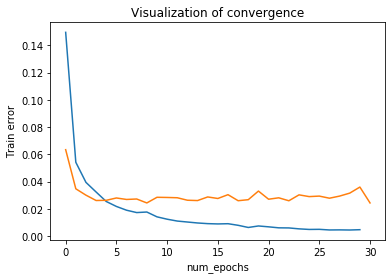

In [0]:
# plot the training error wrt. the number of epochs: 
plt.figure(figsize=)
plt.plot(train_error,label='Train error', )
plt.plot(val_error,label='Val error')
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")